In [ ]:
# !pip install numpy matplotlib cvxopt pandas yfinance finquant plotly cufflinks chart_studio pandas_datareader atoti atoti-jupyterlab

In [ ]:
%matplotlib inline
import random

import cvxopt as opt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from cvxopt import blas, solvers
from finquant.portfolio import build_portfolio
from scipy.optimize import minimize
import pandas_datareader.data as web
import contextlib

np.random.seed(123)

# Turn off progress printing
solvers.options["show_progress"] = False
import concurrent.futures
import os
import random
import urllib
import urllib.request
from concurrent.futures import ALL_COMPLETED, wait

import atoti as tt
import cufflinks
import numpy as np
import pandas_market_calendars as mcal

# (*) To communicate with Plotly's server, sign in with credentials file
import plotly as py

# (*) Useful Python/Plotly tools
import plotly.tools as tls

# (*) Graph objects to piece together plots
from plotly.graph_objs import *

In [ ]:
# ndays = 252*10+7
ndays = 252 * 1.5 + 7
# ~training
dback = 252
# ~forecast
dahead = 20
# sample size
# if to randomize
rand = True
nran = 20
nstocks = 100
# this should match tbill 20, 91, 126, 252

end = pd.Timestamp.utcnow()
start = end - int(ndays) * pd.tseries.offsets.BDay()
one_week_end = end - int(ndays - 7) * pd.tseries.offsets.BDay()
one_week_end = one_week_end.strftime("%Y-%m-%d")
start = start.strftime("%Y-%m-%d")
end = end.strftime("%Y-%m-%d")

In [ ]:
# pd.tseries.offsets.BDay(100)
nyse = mcal.get_calendar("NYSE")

# Show available calendars
# print(mcal.get_calendar_names())
tradingDays = list(
    nyse.schedule(start_date=start, end_date=end).index.strftime("%Y-%m-%d")
)

In [ ]:
def rand_weights(n):
    """ Produces n random weights that sum to 1 """
    k = np.random.rand(n)
    return k / sum(k)


def weighted_return(returns, weights):
    w = weights

    p = np.asmatrix(np.mean(returns, axis=0))

    mu = np.asmatrix(w) * p.T
    return mu


def random_portfolio(TREASURY_BILL_RATE,returns):

    w = rand_weights(len(pd.DataFrame(returns).columns))

    p = np.asmatrix(np.mean(returns, axis=0))

    #print(returns)
    C = np.array(pd.DataFrame(returns).cov().values)
    #print(C)

    mu = np.asmatrix(w) * p.T
    #print(w)
    sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)

    sharpe = (mu-TREASURY_BILL_RATE)/sigma
    #sharpe = mu / sigma

    return np.float(mu), np.float(sigma), np.float(sharpe), np.array(w, dtype=object)

def unique(list1):

    # intilize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return unique_list


def split_sequences(sequences, n_steps_in, n_steps_out):

    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [ ]:
url = "ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt"

urllib.request.urlretrieve(url, "nasdaqtraded.txt")
urllib.request.urlretrieve(url, "mfundslist.txt")
urllib.request.urlretrieve(url, "bonds.txt")

df1 = pd.read_csv("nasdaqtraded.txt", sep="|")[0:-1]
df2 = pd.read_csv("mfundslist.txt", sep="|")[0:-1]
df3 = pd.read_csv("bonds.txt", sep="|")[0:-1]

# combined = pd.concat([df1['Symbol'],df2['Symbol'],df3['Symbol']],axis=0)

# process symbols for bad characters
BAD_CHARS = ["$", "."]
# pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])
# cleaned = unique(combined.replace(BAD_CHARS,'-'))

# choose size
size = nstocks
# stocks = list(df1["Symbol"].sample(n=int(size/3)))
stocks = list(
    df1["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
mfunds = list(
    df2["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
bonds = list(
    df3["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
symbols = list(set(stocks + mfunds + bonds))  # unique(stocks + mfunds + bonds)
# symbols = unique(stocks)

In [ ]:
print(start, one_week_end)

In [ ]:
pf_pre = build_portfolio(
    names=symbols, start_date=start, end_date=one_week_end, data_api="yfinance"
)

In [ ]:
vetted_symbols = list(
    pf_pre.data.loc[
        (np.intersect1d(list(pf_pre.data.index.strftime("%Y-%m-%d")), tradingDays))
    ]
    .head(-1)
    .tail(-1)
    .dropna(axis=1)
    .columns
)

In [ ]:
# combinedList = unique(list(np.append(random.sample(symbols_sp500,int(len(symbols_sp500)*.05)),np.append(random.sample(dividendAristocraft,int(len(dividendAristocraft)*.25)),np.append(top10,random.sample(symbols_ns100,int(len(symbols_ns100)*.25)))))))

# add index
# vetted_symbols.append('TQQQ')

pf = build_portfolio(
    names=list(vetted_symbols), start_date=start, end_date=end, data_api="yfinance"
)

In [ ]:
"""
import pandas_datareader.data as web

import datetime

# Multiple series:
fred_data = web.DataReader(FRED_Indicators, 'fred', start, end)
"""

FRED_Indicators = ["DTB4WK", "DTB3", "DTB6", "DTB1YR"]

def Fred_Data(name):
    temp = web.DataReader(str(name), "fred", start, end)
    temp.index = pd.to_datetime(temp.index)
    # temp = temp.resample(frequency).mean().dropna()
    return temp


FRED_set = []
FRED_completed = []
for i in FRED_Indicators:
    FRED_completed.append(i)
    FRED_set.append(Fred_Data(i))

FRED_pvt = pd.DataFrame()

for x in range(0, len(FRED_completed)):
    values = FRED_set[x]
    values = values.loc[~values.index.duplicated(keep="last")]

    FRED_pvt = pd.concat([FRED_pvt, values], axis=1)

In [ ]:
returns = np.log(
    1
    + pf.data.loc[
        (np.intersect1d(list(pf.data.index.strftime("%Y-%m-%d")), tradingDays))
    ]
    .head(-1)
    .interpolate(method="time")
    .pct_change()
    .tail(-1)
)
returns = returns.dropna(axis=1)
# returns.columns = stocks.dropna(axis=1)
len(returns.columns)
# np.sum(returns.isin([np.inf, -np.inf, np.NaN])).sort_values(kind="quicksort", ascending=True)

In [ ]:
selectedmfunds = set(mfunds) & set(returns.columns)
selectedstocks = set(stocks) & set(returns.columns)
selectedbonds = set(bonds) & set(returns.columns)

In [ ]:
n_steps_in = dback

n_steps_out = dahead

Training, Holdout = split_sequences(
    np.array(pd.DataFrame(returns.index.strftime("%Y-%m-%d"))), n_steps_in, n_steps_out
)

In [ ]:
FRED_pvt.columns

In [ ]:
#stocks.melt(ignore_index=False)
prices = returns.melt(ignore_index=False).reset_index()

In [ ]:
session = tt.create_session(config={"user_content_storage": "./content"})

In [ ]:
prices_table = session.read_pandas(
    prices,
    keys=["Date", "variable"],
    table_name="prices",
)
#prices_table.head()

cube = session.create_cube(prices_table)

In [ ]:
cube.schema

In [ ]:
session.visualize()

In [ ]:
h = cube.hierarchies
l = cube.levels
m = cube.measures

In [ ]:
l

In [ ]:
cube.query(m["contributors.COUNT"])

In [ ]:
#display(cube.query(m["value.SUM"], levels=[l["Date"]]))

display(cube.query(m["value.MEAN"], levels=[l["variable"]]))

In [ ]:
FRED_pvt['DTB4WK'].interpolate().plot()

0.0


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,LKOR,VGR,IDIV,CME,JTD,UDR,WBND,FUN,IJS,CPHC
Weights,0.199123,0.016487,0.011531,0.001032,0.220832,0.036577,0.214986,0.02172,0.136839,0.140874


non weighted return Training


0.0010360228743495458

non weighted Return Holdout


,LKOR,VGR,IDIV,CME,JTD,UDR,WBND,FUN,IJS,CPHC
0,0.001439,-0.00087,-0.000122,0.000214,0.000522,0.002975,0.000297,0.00089,0.000249,0.009708


optimal Weights & Return holdout


,LKOR,VGR,IDIV,CME,JTD,UDR,WBND,FUN,IJS,CPHC
0,0.135768,0.038048,0.10571,0.047623,0.139865,0.001002,0.188148,0.080226,0.107261,0.156351


0.0019869371447089274

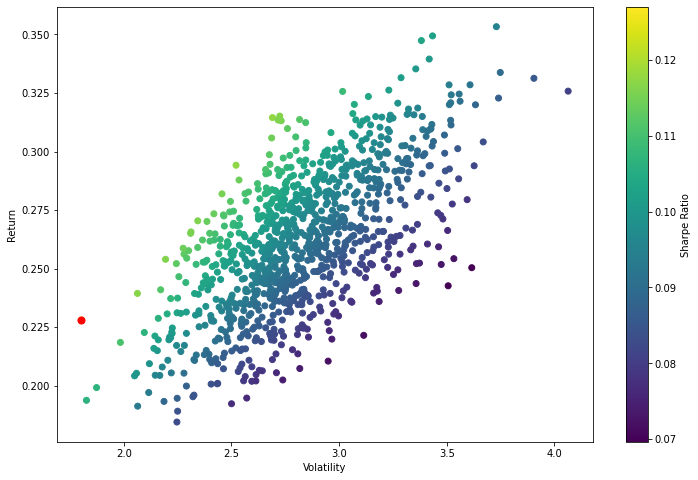

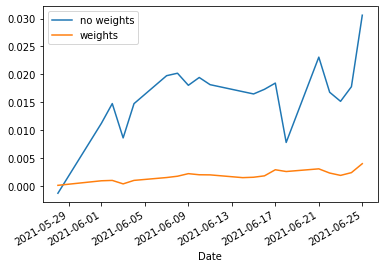

0.01


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,IBHB,MSA,ARDX,ESTA,ERC,CME,CSWI,ENR-PA,PNBK,VGR
Weights,0.143305,0.179028,0.012145,0.127501,0.168059,0.097159,0.171915,0.026308,0.058416,0.016164


non weighted return Training


0.001379867455392403

non weighted Return Holdout


,IBHB,MSA,ARDX,ESTA,ERC,CME,CSWI,ENR-PA,PNBK,VGR
0,0.00007,-0.00122,0.0047,0.006954,-0.00053,-0.000639,0.000552,-0.001326,0.003693,0.000205


optimal Weights & Return holdout


,IBHB,MSA,ARDX,ESTA,ERC,CME,CSWI,ENR-PA,PNBK,VGR
0,0.104826,0.157415,0.06232,0.119887,0.077186,0.079899,0.082024,0.086563,0.074537,0.155343


0.0008669389032538388

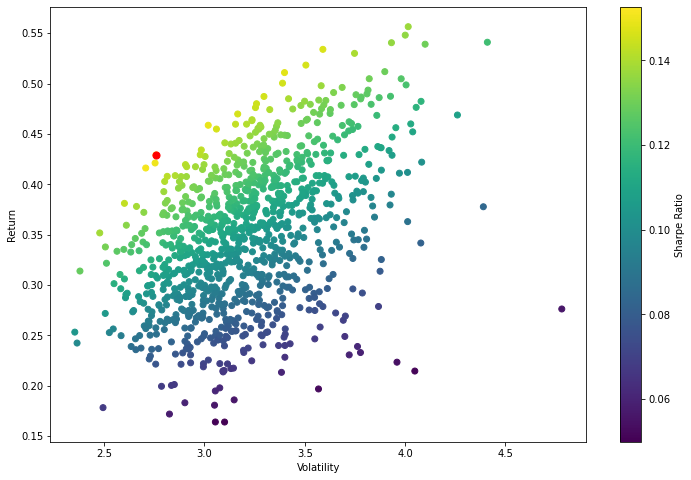

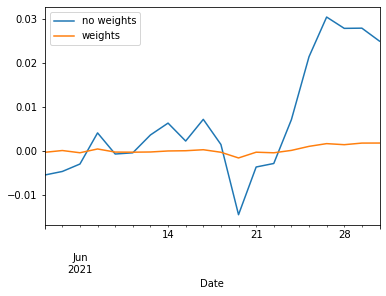

0.0


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,BHFAP,TNA,PNBK,APRE,FLIA,ACWX,ACHC,ECF,EEH,PML
Weights,0.057707,0.039459,0.031039,0.005048,0.127337,0.08768,0.154337,0.147389,0.161926,0.188079


non weighted return Training


0.0007211535778941645

non weighted Return Holdout


,BHFAP,TNA,PNBK,APRE,FLIA,ACWX,ACHC,ECF,EEH,PML
0,0.001801,0.00316,0.006466,0.006074,0.00017,-0.000394,-0.001144,0.002291,0.000253,0.001138


optimal Weights & Return holdout


,BHFAP,TNA,PNBK,APRE,FLIA,ACWX,ACHC,ECF,EEH,PML
0,0.022598,0.064589,0.020757,0.010174,0.172321,0.076757,0.084591,0.17784,0.162989,0.207384


0.0008647758607995884

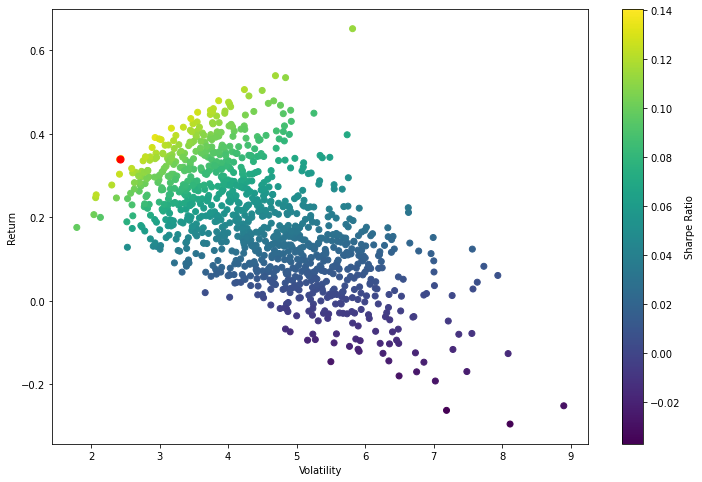

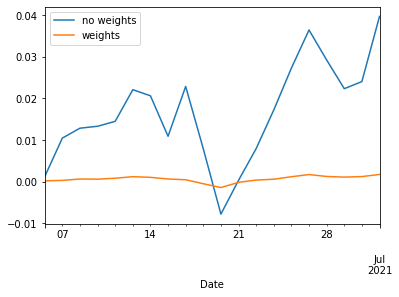

0.04


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,PNBK,PSC,VATE,ESTA,AGO,PMAR,ARMK,AGQ,IDIV,PGX
Weights,0.070883,0.197863,0.044911,0.2451,0.1532,0.001181,0.024593,0.045757,0.087685,0.128828


non weighted return Training


0.002072695114613175

non weighted Return Holdout


,PNBK,PSC,VATE,ESTA,AGO,PMAR,ARMK,AGQ,IDIV,PGX
0,-0.002855,-0.001738,-0.006392,-0.007824,-0.000438,0.000245,-0.002265,-0.005941,0.00141,-0.000294


optimal Weights & Return holdout


,PNBK,PSC,VATE,ESTA,AGO,PMAR,ARMK,AGQ,IDIV,PGX
0,0.081607,0.003639,0.052857,0.182788,0.11945,0.172049,0.116307,0.143069,0.066159,0.062075


-0.0030494866883783583

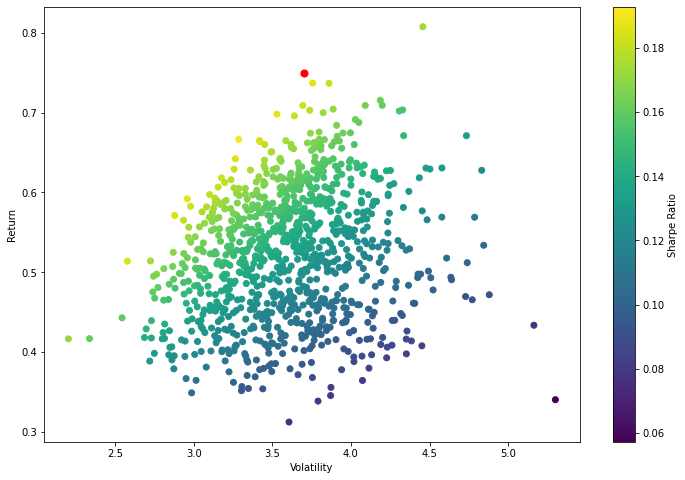

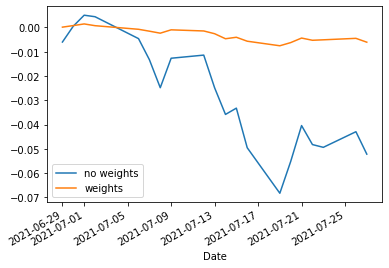

0.04


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,TAL,IGHG,KSU,VCRA,GENE,PSC,ULTR,VATE,ABB,CHIS
Weights,0.006615,0.119477,0.190595,0.067144,0.018605,0.152933,0.150027,0.008699,0.183121,0.102784


non weighted return Training


0.0009737033072716679

non weighted Return Holdout


,TAL,IGHG,KSU,VCRA,GENE,PSC,ULTR,VATE,ABB,CHIS
0,-0.068962,-0.000336,-0.00438,0.00072,-0.010864,-0.001343,0.000024,-0.003261,0.003267,-0.006783


optimal Weights & Return holdout


,TAL,IGHG,KSU,VCRA,GENE,PSC,ULTR,VATE,ABB,CHIS
0,0.045116,0.115773,0.127581,0.129702,0.069705,0.156363,0.080539,0.013918,0.123333,0.13797


-0.0017921171520500628

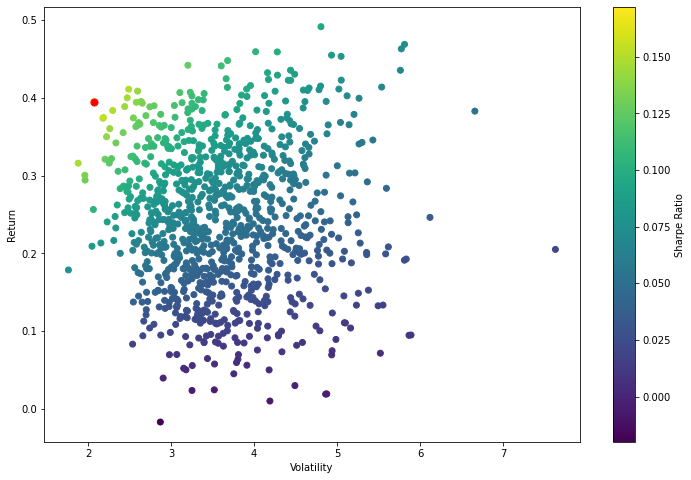

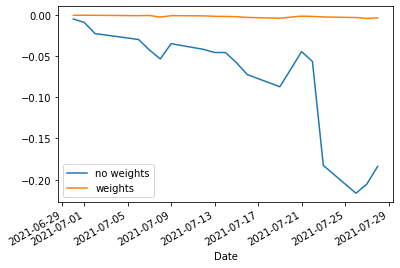

0.05


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,OGS,LKOR,TAL,PMAR,WBND,IXP,GLG,HOOK,CHIS,MSA
Weights,0.023457,0.03376,0.028043,0.051042,0.202579,0.223161,0.029031,0.01887,0.144094,0.245962


non weighted return Training


-0.000313913196632266

non weighted Return Holdout


,OGS,LKOR,TAL,PMAR,WBND,IXP,GLG,HOOK,CHIS,MSA
0,-0.000606,0.001125,-0.067469,0.00022,0.000532,-0.000098,-0.011284,-0.00946,-0.008515,-0.000508


optimal Weights & Return holdout


,OGS,LKOR,TAL,PMAR,WBND,IXP,GLG,HOOK,CHIS,MSA
0,0.030759,0.109924,0.006702,0.236848,0.066638,0.247971,0.048298,0.034173,0.094745,0.123942


-0.0035587524415121126

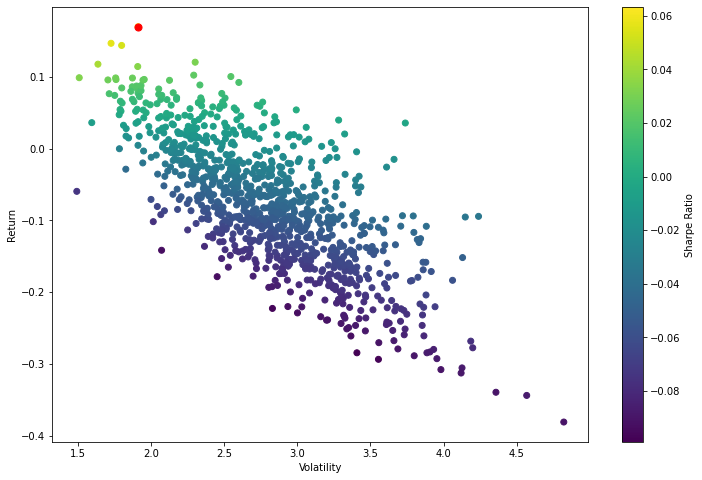

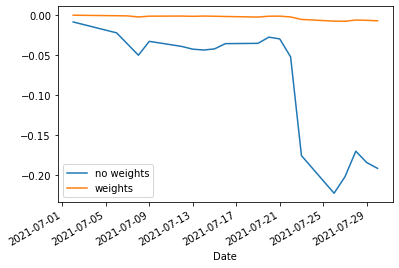

0.05


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,ECF,APRE,GENE,BSTZ,HOOK,OGS,CHIS,MINC,PML,ARMK
Weights,0.103664,0.02028,0.004981,0.20226,0.059279,0.154318,0.041153,0.041397,0.0815,0.291167


non weighted return Training


-0.00037616022663702924

non weighted Return Holdout


,ECF,APRE,GENE,BSTZ,HOOK,OGS,CHIS,MINC,PML,ARMK
0,-0.001614,-0.011552,-0.000747,0.000814,-0.00546,-0.000505,-0.00533,-0.00003,0.000362,0.00056


optimal Weights & Return holdout


,ECF,APRE,GENE,BSTZ,HOOK,OGS,CHIS,MINC,PML,ARMK
0,0.124363,0.003771,0.119363,0.118538,0.002153,0.075696,0.165318,0.118396,0.115015,0.157386


-0.0006673600824612197

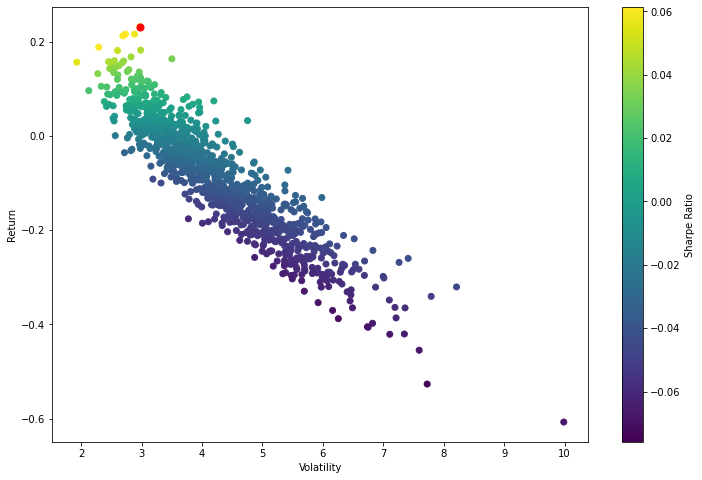

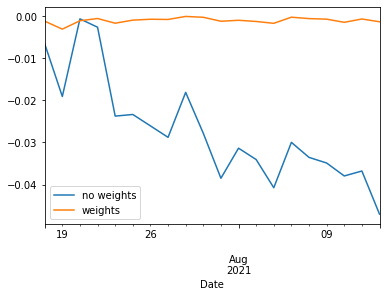

0.05


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,ECF,SMLP,ESTA,CYB,PRDO,BSTZ,APEI,ACWX,ARDX,GVP
Weights,0.046182,0.131262,0.197488,0.204095,0.019746,0.153941,0.006436,0.159651,0.062581,0.01862


non weighted return Training


0.001478330085779677

non weighted Return Holdout


,ECF,SMLP,ESTA,CYB,PRDO,BSTZ,APEI,ACWX,ARDX,GVP
0,0.000103,-0.000803,-0.002922,0.000235,-0.000708,0.002048,-0.001751,0.001375,-0.081788,0.000699


optimal Weights & Return holdout


,ECF,SMLP,ESTA,CYB,PRDO,BSTZ,APEI,ACWX,ARDX,GVP
0,0.189965,0.154598,0.193141,0.11644,0.015888,0.074277,0.014241,0.074538,0.08342,0.083492


-0.005020634058237465

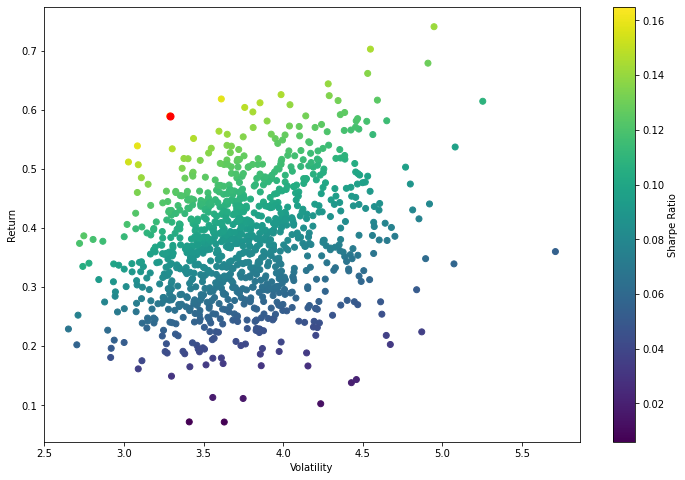

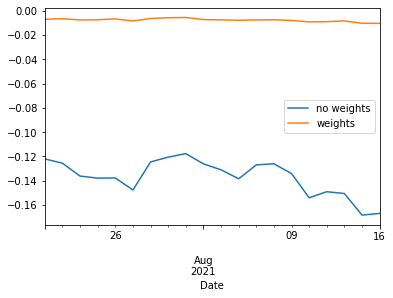

0.05


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,VGR,ARMK,AGO,AMZN,MSA,ECF,AGQ,MGNI,PMAR,BHFAP
Weights,0.025717,0.150032,0.287838,0.00157,0.127931,0.071985,0.006439,0.157918,0.075981,0.094591


non weighted return Training


0.001532999039236885

non weighted Return Holdout


,VGR,ARMK,AGO,AMZN,MSA,ECF,AGQ,MGNI,PMAR,BHFAP
0,0.003179,-0.000021,0.000074,0.001274,0.000876,0.000717,-0.005678,0.00047,0.00034,0.000027


optimal Weights & Return holdout


,VGR,ARMK,AGO,AMZN,MSA,ECF,AGQ,MGNI,PMAR,BHFAP
0,0.101579,0.031562,0.204035,0.044225,0.083015,0.089883,0.060183,0.120037,0.061066,0.204416


0.000332027248749255

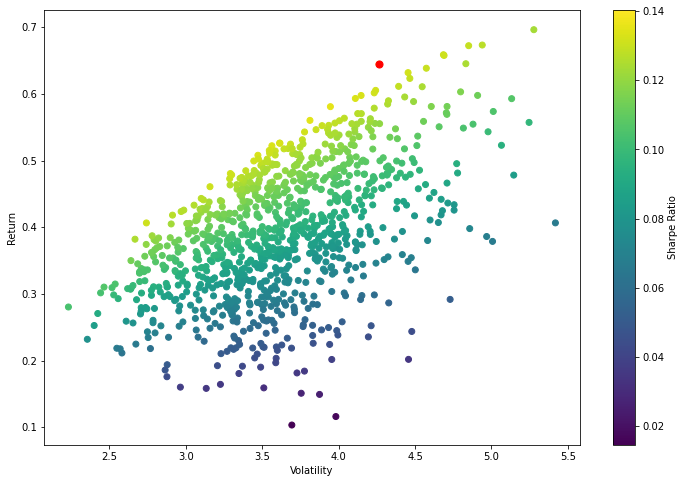

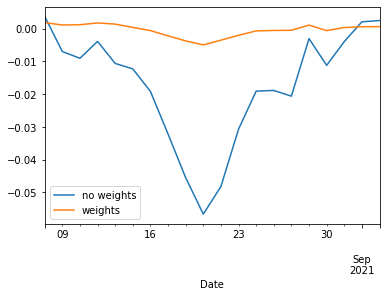

0.04


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,SMLP,PML,ENR-PA,IXP,CME,ESGY,PBTP,AGO,LEVI,GLG
Weights,0.092211,0.164028,0.002261,0.067255,0.182224,0.154328,0.017975,0.014204,0.298192,0.007321


non weighted return Training


0.0008474138765807019

non weighted Return Holdout


,SMLP,PML,ENR-PA,IXP,CME,ESGY,PBTP,AGO,LEVI,GLG
0,-0.004777,-0.000104,-0.000434,0.002092,-0.00359,0.001704,0.000255,-0.000985,-0.001267,0.00761


optimal Weights & Return holdout


,SMLP,PML,ENR-PA,IXP,CME,ESGY,PBTP,AGO,LEVI,GLG
0,0.151602,0.172193,0.004133,0.100505,0.012423,0.097119,0.163104,0.111021,0.168173,0.019727


-0.0010375310590360774

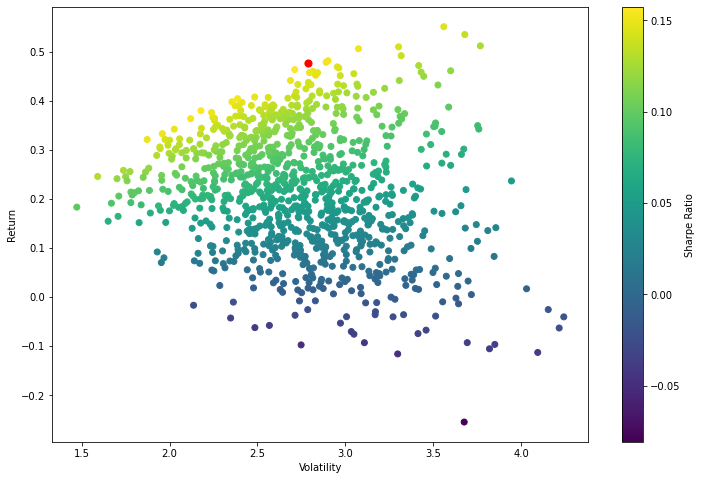

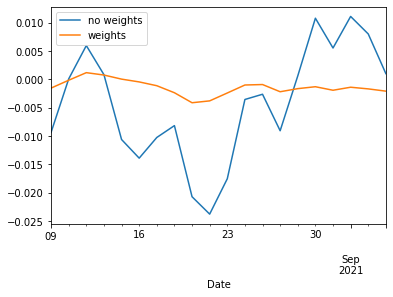

0.05


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,PNBK,KBAL,PMAR,GVP,BHFAP,CSWI,ABB,IBHB,UDR,ERC
Weights,0.100473,0.006121,0.018255,0.023478,0.033203,0.210109,0.152759,0.011634,0.149329,0.294638


non weighted return Training


0.0010527095284771854

non weighted Return Holdout


,PNBK,KBAL,PMAR,GVP,BHFAP,CSWI,ABB,IBHB,UDR,ERC
0,0.001016,-0.002489,0.000164,-0.009923,0.000584,-0.000262,-0.001245,0.000126,0.000243,0.001042


optimal Weights & Return holdout


,PNBK,KBAL,PMAR,GVP,BHFAP,CSWI,ABB,IBHB,UDR,ERC
0,0.069434,0.015751,0.04047,0.015921,0.087931,0.21279,0.255894,0.033627,0.052248,0.215933


-2.2504633283709123e-05

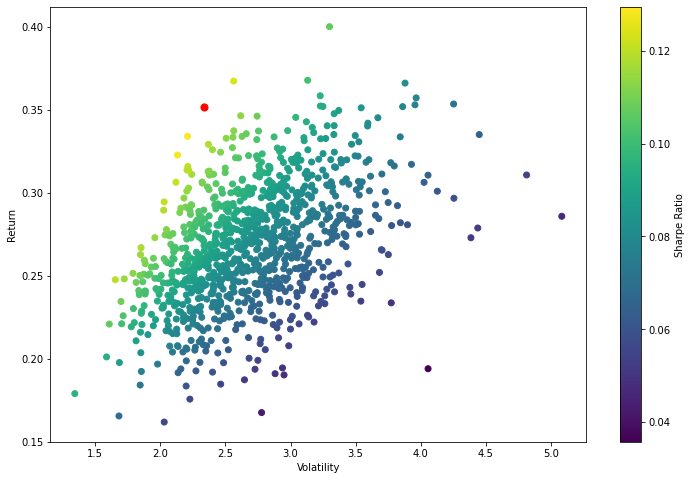

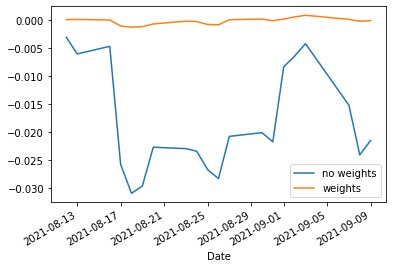

0.05


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,SMLP,ERC,IXP,CYB,ESGY,IGHG,APRE,ULTR,GVP,PMAR
Weights,0.105554,0.103437,0.155011,0.129218,0.145266,0.142677,0.00368,0.087434,0.02167,0.106054


non weighted return Training


0.00019085716796996024

non weighted Return Holdout


,SMLP,ERC,IXP,CYB,ESGY,IGHG,APRE,ULTR,GVP,PMAR
0,-0.004813,0.002576,0.000976,0.000161,0.00111,0.000337,0.006382,0.000062,-0.006727,-0.000071


optimal Weights & Return holdout


,SMLP,ERC,IXP,CYB,ESGY,IGHG,APRE,ULTR,GVP,PMAR
0,0.21881,0.057736,0.161005,0.021401,0.069707,0.161201,0.012757,0.176407,0.108582,0.012395


1.7779407743245865e-05

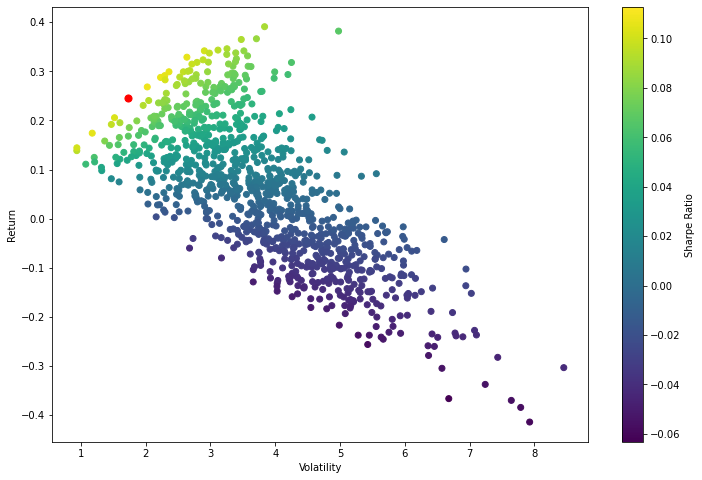

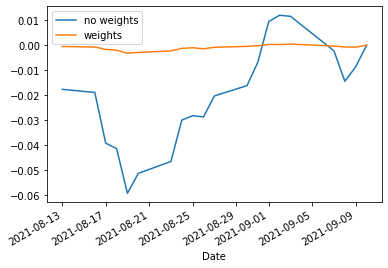

0.04


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,JTD,APRE,ACHC,ACWX,TWM,LKOR,PML,VATE,ECF,SMM
Weights,0.18683,0.00181,0.196697,0.154518,0.012416,0.215623,0.065665,0.053934,0.079491,0.033017


non weighted return Training


-0.0003496649745443033

non weighted Return Holdout


,JTD,APRE,ACHC,ACWX,TWM,LKOR,PML,VATE,ECF,SMM
0,0.000186,0.01944,0.000492,0.001066,-0.00521,0.000342,0.000163,0.002507,-0.000986,0.007803


optimal Weights & Return holdout


,JTD,APRE,ACHC,ACWX,TWM,LKOR,PML,VATE,ECF,SMM
0,0.093955,0.051569,0.262521,0.002819,0.016337,0.061795,0.150532,0.210697,0.147649,0.002126


0.0006675527184085209

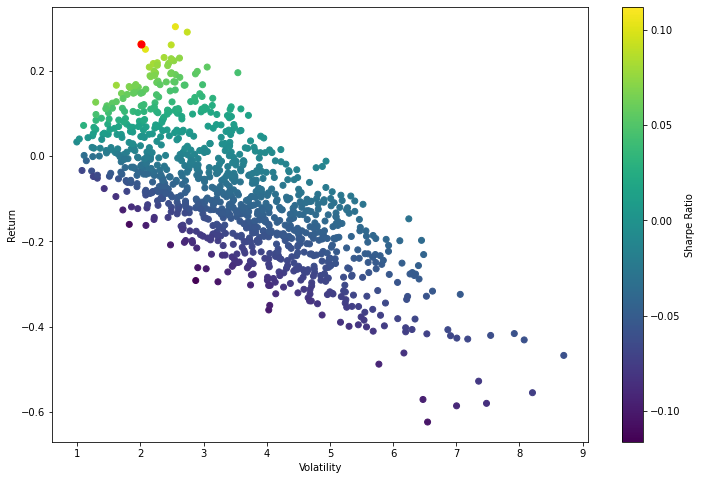

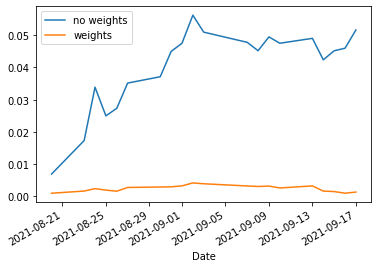

0.04


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,AGO,PRDO,AMZN,FUN,PBTP,CHIS,ECF,GLG,ENR-PA,CSWI
Weights,0.196363,0.016929,0.176208,0.249399,0.016055,0.002983,0.107656,0.009247,0.039482,0.185678


non weighted return Training


0.00024498203791094834

non weighted Return Holdout


,AGO,PRDO,AMZN,FUN,PBTP,CHIS,ECF,GLG,ENR-PA,CSWI
0,-0.003497,-0.001024,0.002377,0.001048,0.000326,-0.000787,-0.002687,-0.00686,-0.001372,-0.003678


optimal Weights & Return holdout


,AGO,PRDO,AMZN,FUN,PBTP,CHIS,ECF,GLG,ENR-PA,CSWI
0,0.181596,0.01153,0.169741,0.075069,0.01449,0.004846,0.076002,0.063466,0.195612,0.207646


-0.0011069382657374297

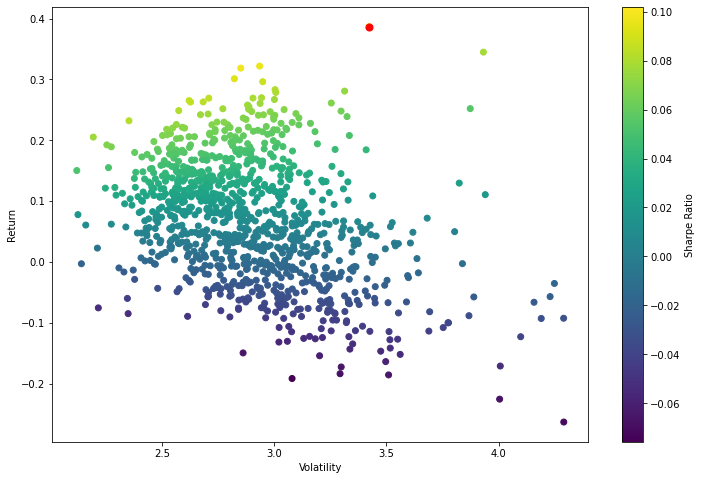

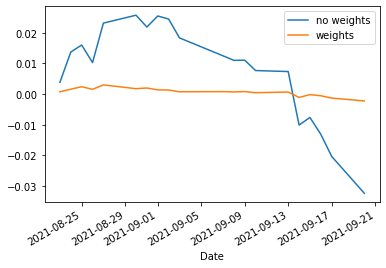

0.04


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,PSC,PRDO,IGHG,ABB,GVP,AGO,GENE,VATE,AMZN,IDIV
Weights,0.14148,0.016204,0.189585,0.216758,0.008229,0.084946,0.006478,0.061689,0.12768,0.146951


non weighted return Training


0.0007282153243660956

non weighted Return Holdout


,PSC,PRDO,IGHG,ABB,GVP,AGO,GENE,VATE,AMZN,IDIV
0,-0.000592,-0.002855,0.000509,-0.00222,0.009683,-0.002796,0.000298,0.003064,0.00174,0.001192


optimal Weights & Return holdout


,PSC,PRDO,IGHG,ABB,GVP,AGO,GENE,VATE,AMZN,IDIV
0,0.165575,0.036453,0.078289,0.01049,0.093912,0.253113,0.080255,0.100211,0.14747,0.034231


-8.245460240909939e-05

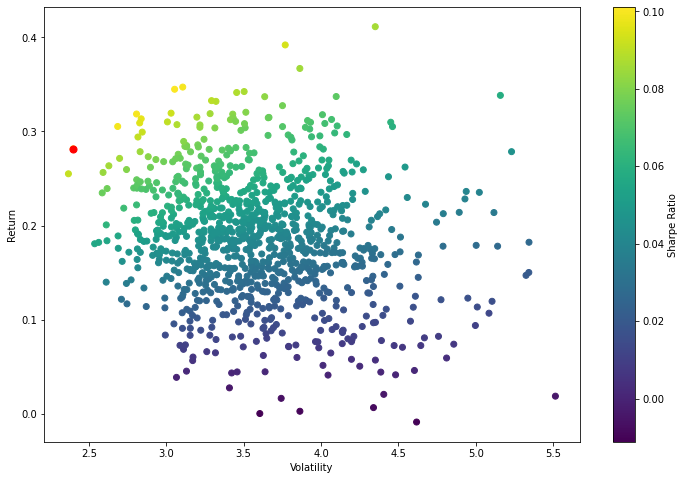

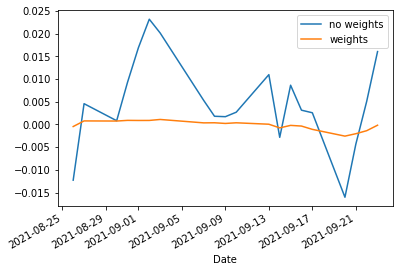

0.07


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,KBAL,JTD,IJS,TTAI,PBTP,APEI,UDR,EDIT,IBHB,VATE
Weights,0.01191,0.138142,0.284873,0.20579,0.017451,0.019502,0.103188,0.060265,0.136703,0.022177


non weighted return Training


0.001133977077086993

non weighted Return Holdout


,KBAL,JTD,IJS,TTAI,PBTP,APEI,UDR,EDIT,IBHB,VATE
0,-0.00209,-0.001874,0.002034,-0.00247,-0.000058,-0.000169,0.000319,-0.025078,-0.000056,0.003616


optimal Weights & Return holdout


,KBAL,JTD,IJS,TTAI,PBTP,APEI,UDR,EDIT,IBHB,VATE
0,0.119194,0.103233,0.055971,0.130812,0.063154,0.022519,0.15489,0.067924,0.182023,0.100282


-0.0016024749974683488

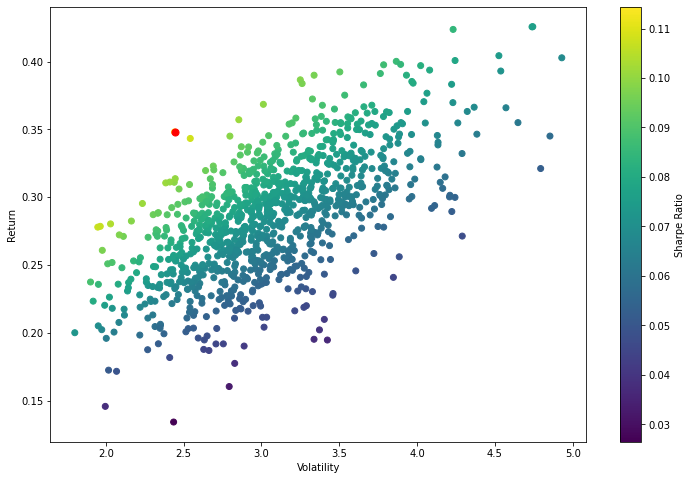

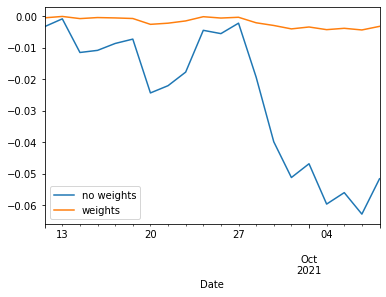

0.05


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,TTAI,PBTP,BAC-PB,IXP,IDIV,MGNI,ACHC,PGX,ESTA,ARDX
Weights,0.118603,0.165378,0.12167,0.161187,0.003705,0.10883,0.164751,0.01204,0.143458,0.000379


non weighted return Training


0.0012175581045054582

non weighted Return Holdout


,TTAI,PBTP,BAC-PB,IXP,IDIV,MGNI,ACHC,PGX,ESTA,ARDX
0,-0.002874,0.000006,0.000204,-0.002747,-0.000347,-0.001563,-0.003652,-0.000664,0.002382,0.001539


optimal Weights & Return holdout


,TTAI,PBTP,BAC-PB,IXP,IDIV,MGNI,ACHC,PGX,ESTA,ARDX
0,0.173146,0.134849,0.106376,0.126249,0.061201,0.025335,0.075088,0.135396,0.159269,0.003091


-0.0011938415224914303

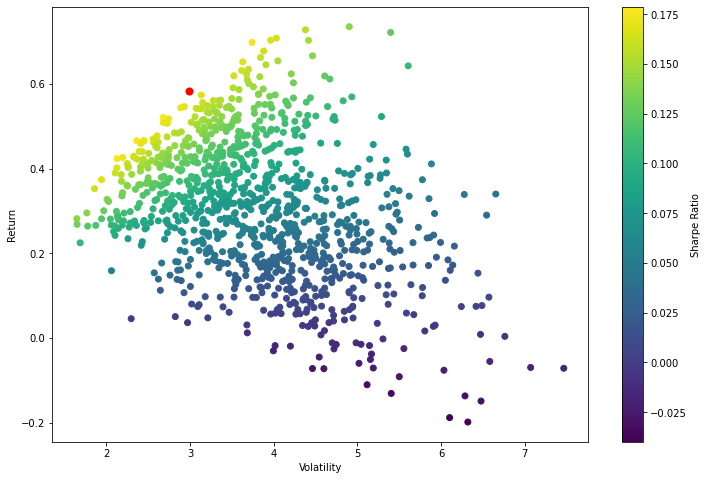

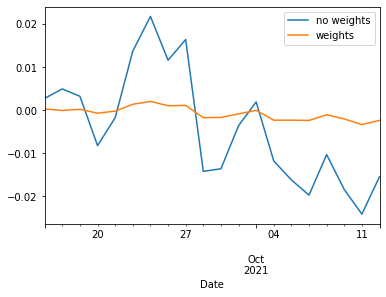

0.07


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,PBTP,KSU,SMLP,CHIS,HOOK,ESTA,TWM,GVP,VCRA,LKOR
Weights,0.060348,0.194034,0.190836,0.018421,0.019411,0.210483,0.011145,0.00576,0.134566,0.154996


non weighted return Training


0.0009342553183065858

non weighted Return Holdout


,PBTP,KSU,SMLP,CHIS,HOOK,ESTA,TWM,GVP,VCRA,LKOR
0,0.000481,0.005219,-0.005744,0.002326,-0.01234,0.009017,-0.0032,-0.000344,0.00622,0.000127


optimal Weights & Return holdout


,PBTP,KSU,SMLP,CHIS,HOOK,ESTA,TWM,GVP,VCRA,LKOR
0,0.163013,0.110174,0.139398,0.017645,0.025758,0.153429,0.07937,0.126581,0.056086,0.128546


0.0024843902429812

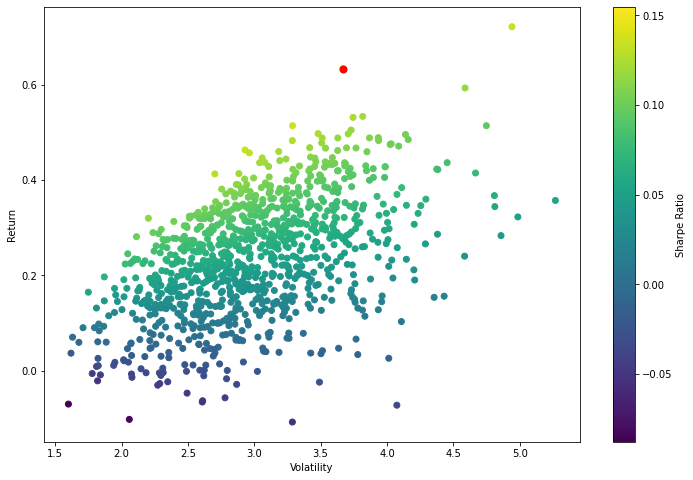

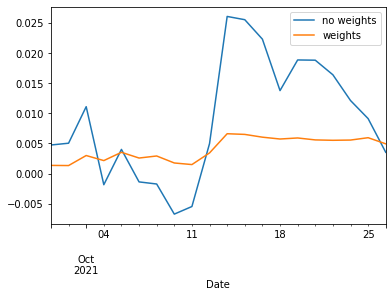

0.02


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,MSA,KBAL,AGQ,BHFAP,IBHB,CSR,IXP,GLG,ABB,PML
Weights,0.028208,0.024224,0.030737,0.090127,0.014737,0.176006,0.239054,0.016771,0.183094,0.197043


non weighted return Training


-0.00021003739163595993

non weighted Return Holdout


,MSA,KBAL,AGQ,BHFAP,IBHB,CSR,IXP,GLG,ABB,PML
0,0.001707,-0.001391,0.006386,0.002867,0.000087,0.002203,0.00068,0.002256,0.00219,-0.00104


optimal Weights & Return holdout


,MSA,KBAL,AGQ,BHFAP,IBHB,CSR,IXP,GLG,ABB,PML
0,0.023064,0.17125,0.024669,0.129392,0.150456,0.155958,0.063248,0.02757,0.168412,0.08598


0.0012567577161945076

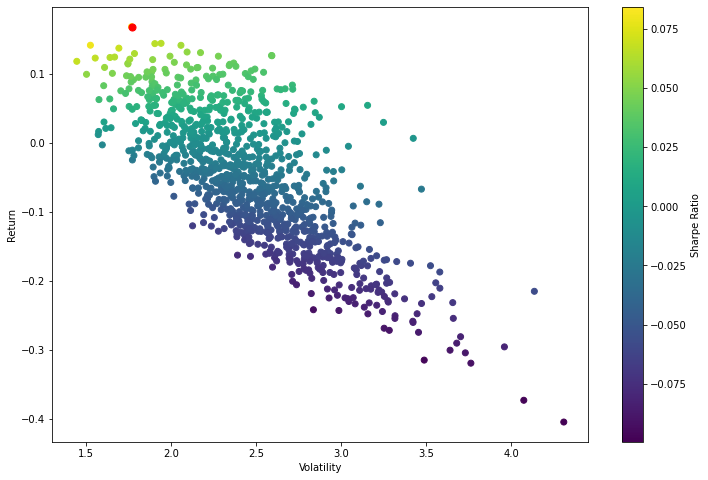

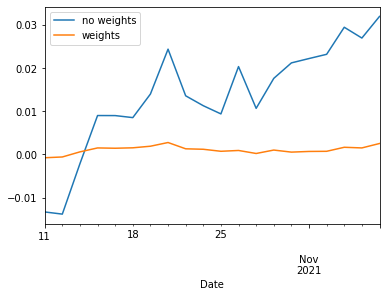

0.02


C:\Users\User\AppData\Local\Temp/ipykernel_9964/513388286.py:33: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,ULTR,APRE,EEH,SMM,ACHC,KSU,TTAI,FLIA,ENR-PA,INSW
Weights,0.048004,0.008478,0.133112,0.201336,0.165758,0.183301,0.157141,0.061527,0.014416,0.026928


non weighted return Training


0.00024526353581125193

non weighted Return Holdout


,ULTR,APRE,EEH,SMM,ACHC,KSU,TTAI,FLIA,ENR-PA,INSW
0,-0.000014,-0.003357,0.001624,0.002432,0.00499,0.003865,0.002908,0.000179,-0.000148,0.004343


optimal Weights & Return holdout


,ULTR,APRE,EEH,SMM,ACHC,KSU,TTAI,FLIA,ENR-PA,INSW
0,0.177059,0.003723,0.143849,0.132205,0.014747,0.014121,0.178468,0.171989,0.064487,0.099351


0.0028003006228730634

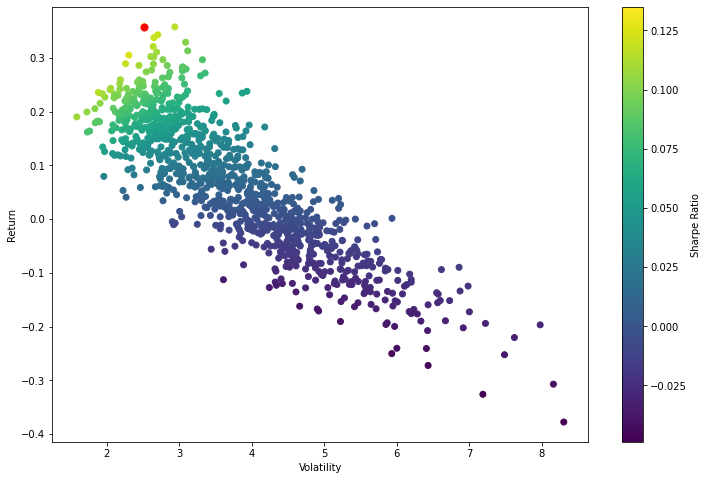

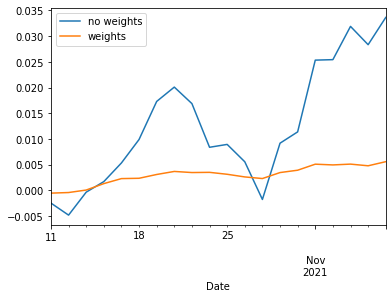

In [156]:
#m["Lookback Window"] = 252

n_portfolio = 100

stocksp = 0.2
mfundsp = 0.1
bondsp = 0.2
commp = 0.2


#simulation

randomSet = list(np.sort(np.random.choice(range(0, len(Training)), nran)))

for tensor in randomSet:

    bestSharpe = 0
    runs = 0
    weight = None
    bestMean = 0
    bestStd = 0
    means = np.array([])
    stds = np.array([])
    sharpes = np.array([])
    bestWeights = None
    weights = np.array([])

    randomsymbols = list(np.random.choice(pf.data.columns, 10, replace=False))
    
    Training_dates = list(Training[tensor].ravel())
    
    TREASURY_BILL_RATE =  FRED_pvt.interpolate()[FRED_pvt.index==Training_dates[-1]]['DTB4WK'].dropna().values[-1]
    print(TREASURY_BILL_RATE)
    
    Holdout_dates = list(Holdout[tensor].ravel())
    
    #this is where atoti currently lacks.  I can't derive a covariance matrix without a full array (see random_portfolio function).
    Training_query = returns.loc[Training_dates][randomsymbols]
    
    Holdout_query = returns.loc[Holdout_dates][randomsymbols]
    
    '''
    Training_query = \
    (
        cube.query(
            m["value.MEAN"],
            levels=[l["variable"]],
            condition=(
            (l["variable"].isin(*randomsymbols))
            & (l["Date"].isin(*Training_dates))
            ),
        )
    )
    '''
    
    names = Training_query.columns
    
    '''
    Holdout_query = \
    (
        cube.query(
            m["value.MEAN"],
            levels=[l["variable"]],
            condition=(
            (l["variable"].isin(*randomsymbols))
            & (l["Date"].isin(*Holdout_dates))
            ),
        )
    )
    '''
    
    #display([dates[0],dates[-1]])
    #display(query.T)
    
    #Monte Carlo efficient frontier
    for _ in range(n_portfolio):
        means2, stds2, sharpes2, weights2 = np.column_stack(
            [random_portfolio((TREASURY_BILL_RATE*1/252.75),Training_query) for _ in range(len(names))]
        )
        means_ = means2
        stds_ = stds2
        sharpes_ = sharpes2
        weights_ = weights2

        bestWeights = weights_[sharpes_.argmax()]

        means = np.append(means, means_)
        stds = np.append(stds, stds_)
        sharpes = np.append(sharpes, sharpes_)
        weights = np.append(weights, weights_)

    df_ = pd.DataFrame(weights[sharpes.argmax()]).set_index(names)
    df_.columns = ["Weights"]

    #next4weeks = returns.loc[[i[0] for i in Holdout[tensor]]][randomsymbols]

    #df_.sort_values(by=["Weights"], ascending=False, inplace=True)

    display(df_.T)
    
    wr = np.array(
        weighted_return(
            np.array((np.exp(pd.DataFrame(Holdout_query.mean()).T) - 1).cumsum().tail(1)),
            weights[sharpes.argmax()],
        )
    )[0][0]
    
    max_sr_ret = means[sharpes.argmax()]
    max_sr_vol = stds[sharpes.argmax()]
    max_sharpe = sharpes[sharpes.argmax()]
    
    print("non weighted return Training")
    display(Training_query.mean().mean())    
    print("non weighted Return Holdout")
    display(pd.DataFrame(Holdout_query.mean()).T)
    #display(pd.DataFrame(Holdout_query.mean()).T.mean())
    
    print("optimal Weights & Return holdout")
    display(pd.DataFrame(bestWeights).set_index(names).T)
    display(wr)

    #display([bestWeights, max_sr_ret, max_sr_vol, max_sharpe, wr])
    
    #'''

    #print('Its location in the array: {}'.format(sharpes.argmax()))

    #print('Optimal Genetic Algorithm Expected Annual Return: {}'.format((np.exp(max_sr_ret)-1)*252.75))
    #print('Optimal Genetic Algorithm Expected Annual Variance: {}'.format((np.exp(max_sr_vol)-1)*252.75))
    #print('Optimal Genetic Algorithm sharpe ratio: {}'.format(max_sharpe))

    plt.figure(figsize=(12,8))
    plt.scatter((np.exp(stds.astype(float))-1)*252.75, (np.exp(means.astype(float))-1)*252.75, c=sharpes, cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')

    #plt.plot((np.exp(risks)-1)*252.75, (np.exp(returns)-1)*252.75, 'y-o')
    plt.scatter((np.exp(max_sr_vol)-1)*252.75, (np.exp(max_sr_ret)-1)*252.75,c='red', s=50) # red dot
    #plt.scatter((np.exp(bestStd)-1)*252.75,(np.exp(bestMean)-1)*252.75,c='purple', s=50) # red dot
    #plt.scatter((np.exp(optimal_risk_free_sharpe[1])-1)*252.75, (np.exp(optimal_risk_free_sharpe[0])-1)*252.75,c='purple', s=50) # red dot
    plt.show()
    
    data0=(Holdout_query).mean(1).cumsum()
    data1=(Holdout_query*weights[sharpes.argmax()]).mean(1).cumsum()
    df = pd.concat([data0,data1],axis=1)
    df.columns = ["no weights","weights"]
    df.plot()
    plt.show()